# Analysis of Split ECG latent space for Model Poisoning Detection

In [6]:
import numpy as np
import os
from torch.nn.functional import max_pool1d, avg_pool1d
import torch
import pickle
import pandas as pd
import scipy.spatial as sp
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from functools import partial
import multiprocessing
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib as mpl
from contextlib import closing
import itertools
#from tqdm.notebook import tqdm
from tqdm import tqdm
import math
from server.security.analysis import *
%load_ext autoreload
%autoreload 2

## Multi-Client Experiments

#### Key Assumptions from the presentation
1. Latent representation of datapoints should only slightly change between epochs 
2. Points of similar classes are close to each other in the latent space
3. Poisoned datapoints have higher loss contributions than regular datapoints

The following metrics and visualizations are interesting to determine if our assumptions (1), (2), and (3) are valid in the multi-client setup.

### Robust Latent Representation

TBA

### Pairwise Class Similarity to Latent Space Proximity

To verify this assumption we use summaries of per-client and per-class pairwise similariities + t-SNE visualization. We do the same for the malicious client vs the honest clients:
- First and second moment + median of pairwise similarities for different similarity measures (primarily Minkowski)
- Comparison of results for fixed class over epochs (plot lines)
- t-SNE visualization of the latent space for fixed class and different epochs

In [2]:
similarities = ["cosine", "euclidean", "cityblock", "correlation", "seuclidean"]
epochs = 30
base_path = "/home/mohkoh/Projects/Split_ECG_Classification/latent_space/multi_client_two_malicious_0.25_0.25"
metadata = pickle.load(open(os.path.join(base_path, "metadata.pickle"), "rb"))

#### Label Distribution

In [ ]:
df = pd.DataFrame()
for client_id in range(1, 6):
    samples = pd.read_pickle(os.path.join(base_path, "client_" + str(client_id), "epoch_" + str(1) + ".pickle"))
    samples.label = samples.label.apply(lambda x: np.sum(x * 2**np.arange(x.size)[::-1]))
    single_class = samples[samples.label.apply(lambda x: is_power_of_2(x))]
    col = single_class.label.value_counts().sort_index().rename("client_" + str(client_id))
    df = pd.concat([df, col], axis=1)

df

#### Moments of Pairwise Similarities

In [ ]:
df_clients = pd.DataFrame(columns=["client_id"])
for idx in range(1, metadata["num_clients"] + 1):
    client_path = os.path.join(base_path, "client_" + str(idx))
    save_path = os.path.join(client_path, "similarities.pickle")
    df = compute_in_parallel(client_path, epochs, similarities, num_workers=multiprocessing.cpu_count(), aggregate=True, pooling=None, split="knn_10_euclidean")
    df["client_id"] = idx
    df_clients = pd.concat([df_clients, df], axis=0, ignore_index=True)

#### Plotting Similarity Metrics for Fixed Class and Individual Clients

In [ ]:
plot_all_similarities(df_clients, moment, similarities=similarities)

In [ ]:
# 0.2 / 0.5
for l in df_clients.label.unique():
    plot_all_similarities(df_clients, l, moment, similarities=similarities)

In [ ]:
# 0.01 / 0.25
for l in df_clients.label.unique():
    plot_all_similarities(df_clients, l, moment, similarities=similarities)

In [ ]:
# 0.1 / 0.5
moment = "mean"

for l in df_clients.label.unique():
    plot_all_similarities(df_clients, l, moment, similarities=similarities)

In [ ]:
# 0.01 / 0.01
moment = "mean"

for l in df_clients.label.unique():
    plot_all_similarities(df_clients, l, moment)

In [ ]:
# 0.5 / 0.1
moment = "mean"

for l in df_clients.label.unique():
    plot_all_similarities(df_clients, l, moment)

In [ ]:
# 0.2 / 0.1
moment = "mean"

for l in df_clients.label.unique():
    plot_all_similarities(df_clients, l, moment)

#### t-SNE Visualization

In [ ]:
epoch_path = os.path.join(base_path, "client_1", "epoch_" + str(1) + ".pickle")
samples = pickle.load(open(epoch_path, "rb"))
samples.columns

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 0.2 / 0.5

params = {
    "n_components": 2, 
    "perplexity": 35, 
    "n_iter": 1000, 
    "verbose": 0, 
    "random_state": 0,
    #"learning_rate": "auto",
    #"init": "pca",
    #"n_jobs": 20
}

fig, ax = per_epoch_tsne([1, 15, 30], base_path, 5, params, pooling=None, pca=50, split="knn_10_euclidean")

In [ ]:
# 0.1 / 0.5

params = {
    "n_components": 2, 
    "perplexity": 35, 
    "n_iter": 1000, 
    "verbose": 0, 
    "random_state": 0,
    #"learning_rate": "auto",
    #"init": "pca",
    #"n_jobs": 20
}

fig, ax = per_epoch_tsne([1, 15, 30], base_path, 5, params, pooling=None, pca=50, split="knn5")

In [ ]:
# 0.01 / 0.01

params = {
    "n_components": 2, 
    "perplexity": 35, 
    "n_iter": 1000, 
    "verbose": 0, 
    "random_state": 0,
    #"learning_rate": "auto",
    #"init": "pca",
    #"n_jobs": 20
}

fig, ax = per_epoch_tsne([1, 15, 30], base_path, 5, params, pooling=None, pca=50, split="knn5")

In [ ]:
# 0.5 / 0.1

params = {
    "n_components": 2, 
    "perplexity": 35, 
    "n_iter": 1000, 
    "verbose": 0, 
    "random_state": 0,
    #"learning_rate": "auto",
    #"init": "pca",
    #"n_jobs": 20
}

fig, ax = per_epoch_tsne([1, 15, 30], base_path, 5, params, pooling=None, pca=50, split="knn5")

In [ ]:
base_path = "/home/mohkoh/Projects/Split_ECG_Classification/latent_space/multi_client_one_malicious_0.01_0.25"

params = {
    "n_components": 2, 
    "perplexity": 35, 
    "n_iter": 1000, 
    "verbose": 0, 
    "random_state": 0,
    #"learning_rate": "auto",
    #"init": "pca",
    #"n_jobs": 20
}

fig, ax = per_epoch_tsne([1, 15, 30], base_path, 5, params, pooling=None, pca=50, split="knn_5_euclidean")


In [ ]:
base_path = "/home/mohkoh/Projects/Split_ECG_Classification/latent_space/multi_client_one_malicious_0.2_0.1"

params = {
    "n_components": 2, 
    "perplexity": 35, 
    "n_iter": 1000, 
    "verbose": 0, 
    "random_state": 0,
    #"learning_rate": "auto",
    #"init": "pca",
    #"n_jobs": 20
}

fig, ax = per_epoch_tsne([1, 15, 30], base_path, 5, params, pooling=None, pca=50, split="knn_5_euclidean")


### Higher Loss Contribution of Corrupted Points and Malicious Client

- Loss contribution of client per epoch 
- Also some moments for the loss of each client per epoch

In [ ]:
plot_loss(loss_contributions(base_path, metadata=metadata), "mean")

In [ ]:
plot_loss(loss_contributions(base_path, "mean"), "mean")

In [ ]:
plot_loss(loss_contributions(base_path, "var"), "var")

In [ ]:
plot_loss(loss_contributions(base_path, "std"), "std")

In [ ]:
plot_loss(loss_contributions(base_path, "sum"), "sum")

## Detection Mechanism

We confirmed our assumptions (1), (2), and (3) for the multi-client setup. Now we can use the following metrics to detect model poisoning:
- Loss contribution of client per epoch	
- Cosine similarity, Correlation , Standardized Euclidean Distance

We will try out different ideas for the detection mechanism and compare them to each other

### Naive Approaches

In [10]:
similarities = ["cosine", "correlation", "seuclidean"]
epochs = 30
base_path = "/home/mohkoh/Projects/Split_ECG_Classification/latent_space/multi_client_two_malicious_0.25_0.25"
metadata = pickle.load(open(os.path.join(base_path, "metadata.pickle"), "rb"))

  0%|          | 0/5 [00:00<?, ?it/s]

/home/mohkoh/.conda/envs/Medical-Split-Learning/lib/python3.9/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


client_id
1    AxesSubplot(0.125,0.11;0.775x0.77)
2    AxesSubplot(0.125,0.11;0.775x0.77)
3    AxesSubplot(0.125,0.11;0.775x0.77)
4    AxesSubplot(0.125,0.11;0.775x0.77)
5    AxesSubplot(0.125,0.11;0.775x0.77)
Name: loss, dtype: object

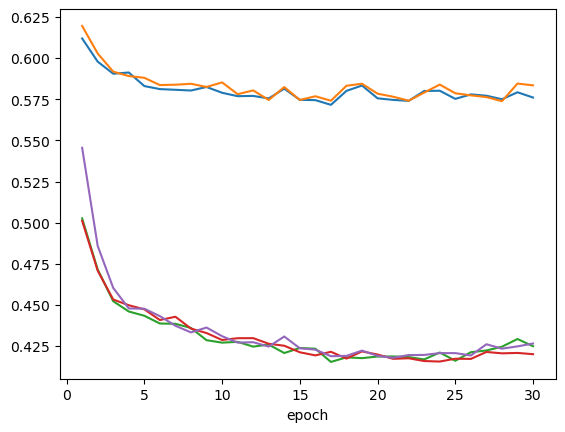

In [59]:
lc = loss_contributions(base_path, metadata=metadata)
lc.set_index("epoch").groupby("client_id")["loss"].plot()

In [5]:
df_clients = pd.DataFrame(columns=["client_id"])
for idx in range(1, metadata["num_clients"] + 1):
    client_path = os.path.join(base_path, "client_" + str(idx))
    save_path = os.path.join(client_path, "similarities.pickle")
    df = compute_in_parallel(client_path, epochs, similarities, num_workers=multiprocessing.cpu_count(), aggregate=True, pooling=None, split="knn_10_euclidean")
    df["client_id"] = idx
    df_clients = pd.concat([df_clients, df], axis=0, ignore_index=True)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [6]:
for sim in similarities:
    df_clients[sim] = df_clients[sim].apply(lambda x: x[0])
df_clients_global = df_clients.groupby(["client_id", "epoch"]).mean()

client_id
1    AxesSubplot(0.125,0.11;0.775x0.77)
2    AxesSubplot(0.125,0.11;0.775x0.77)
3    AxesSubplot(0.125,0.11;0.775x0.77)
4    AxesSubplot(0.125,0.11;0.775x0.77)
5    AxesSubplot(0.125,0.11;0.775x0.77)
Name: cosine, dtype: object

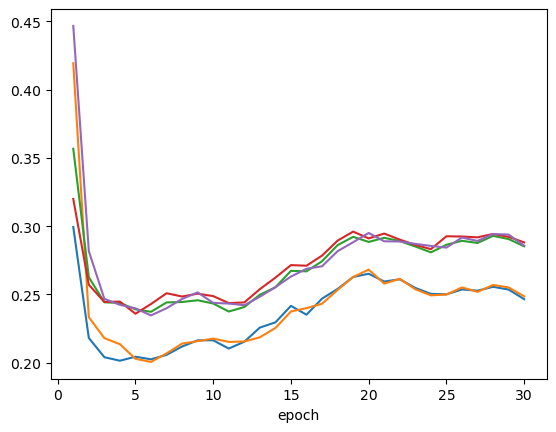

In [7]:
df_clients_global.reset_index(inplace=True)
df_clients_global.set_index("epoch", inplace=True)
df_clients_global.groupby("client_id")["cosine"].plot()

In [61]:
def medianAbsoluteDeviation(x):
    med = x[similarities].median()
    ad = abs(x[similarities] - med)
    exp_ad = np.exp(-ad.astype(np.float64))
    x[similarities] = exp_ad / exp_ad.sum()
    x[similarities] = ad / ad.sum()
    return x

In [39]:
x = np.random.rand(5, 3)
np.exp(x)

array([[1.21590559, 1.78055515, 1.25991463],
       [1.79444772, 2.31016125, 1.13050429],
       [1.76543629, 1.10138628, 1.24776238],
       [2.15283711, 1.67590008, 1.14834035],
       [2.67472144, 1.46094625, 1.26745828]])

client_id
1    AxesSubplot(0.125,0.11;0.775x0.77)
2    AxesSubplot(0.125,0.11;0.775x0.77)
3    AxesSubplot(0.125,0.11;0.775x0.77)
4    AxesSubplot(0.125,0.11;0.775x0.77)
5    AxesSubplot(0.125,0.11;0.775x0.77)
Name: seuclidean, dtype: object

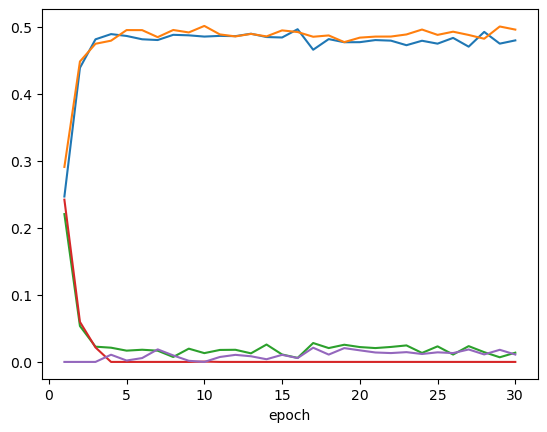

In [62]:
df_ratio = df_clients_global.merge(lc, on=["epoch", "client_id"])
df_ratio[similarities] = (1 / df_ratio[similarities]).multiply(df_ratio["loss"], axis=0)

df_ratio = df_ratio.groupby("epoch").apply(medianAbsoluteDeviation)
df_ratio.reset_index(inplace=True)
df_ratio.set_index("epoch", inplace=True)
df_ratio.groupby("client_id")["seuclidean"].plot()

client_id
1    AxesSubplot(0.125,0.11;0.775x0.77)
2    AxesSubplot(0.125,0.11;0.775x0.77)
3    AxesSubplot(0.125,0.11;0.775x0.77)
4    AxesSubplot(0.125,0.11;0.775x0.77)
5    AxesSubplot(0.125,0.11;0.775x0.77)
Name: cosine, dtype: object

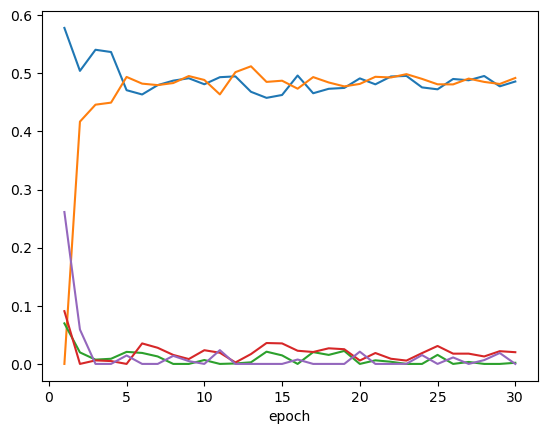

In [114]:
df_ratio = df_clients_global.merge(lc, on=["epoch", "client_id"])
df_ratio[similarities] = (1 / df_ratio[similarities]).multiply(df_ratio["loss"], axis=0)

df_ratio = df_ratio.groupby("epoch").apply(medianAbsoluteDeviation)
df_ratio.reset_index(inplace=True)
df_ratio.set_index("epoch", inplace=True)
df_ratio.groupby("client_id")["cosine"].plot()

client_id
1    AxesSubplot(0.125,0.11;0.775x0.77)
2    AxesSubplot(0.125,0.11;0.775x0.77)
3    AxesSubplot(0.125,0.11;0.775x0.77)
4    AxesSubplot(0.125,0.11;0.775x0.77)
5    AxesSubplot(0.125,0.11;0.775x0.77)
Name: correlation, dtype: object

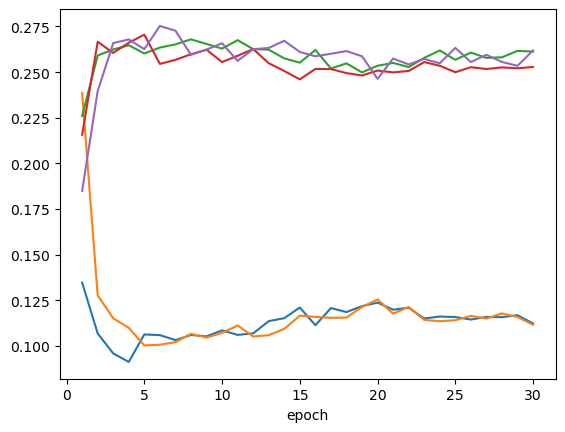

In [94]:
df_ratio = df_clients_global.merge(lc, on=["epoch", "client_id"])
df_ratio[similarities] = (1 / df_ratio[similarities]).multiply(df_ratio["loss"], axis=0)

df_ratio = df_ratio.groupby("epoch").apply(medianAbsoluteDeviation)
df_ratio.reset_index(inplace=True)
df_ratio.set_index("epoch", inplace=True)
df_ratio.groupby("client_id")["correlation"].plot()

client_id
1    AxesSubplot(0.125,0.11;0.775x0.77)
2    AxesSubplot(0.125,0.11;0.775x0.77)
3    AxesSubplot(0.125,0.11;0.775x0.77)
4    AxesSubplot(0.125,0.11;0.775x0.77)
5    AxesSubplot(0.125,0.11;0.775x0.77)
Name: seuclidean, dtype: object

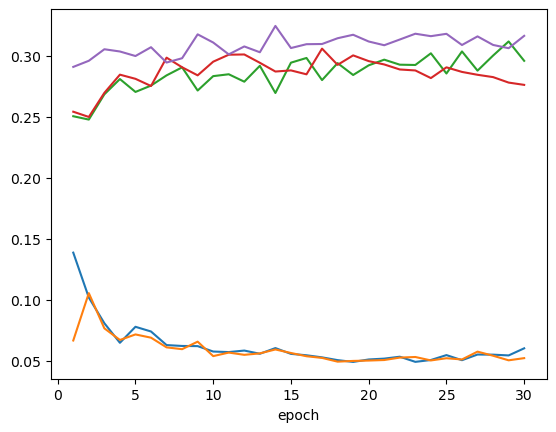

In [95]:
df_ratio = df_clients_global.merge(lc, on=["epoch", "client_id"])
df_ratio[similarities] = df_ratio[similarities].multiply(df_ratio["loss"], axis=0)

df_ratio = df_ratio.groupby("epoch").apply(medianAbsoluteDeviation)
df_ratio.reset_index(inplace=True)
df_ratio.set_index("epoch", inplace=True)
df_ratio.groupby("client_id")["seuclidean"].plot()

In [16]:
def softmaxScheduler(x):
    x_t = torch.from_numpy(x[similarities].to_numpy().astype(np.float32))
    x_t = torch.nn.functional.softmax(-x_t, dim=0) / (1/x_t.shape[0])
    x[similarities] = x_t.numpy()
    return x

#### Discounted Loss Contribution: 

Simple idea: The higher the loss contribution, the lower the probability that the server will perform a backpropagation step. We can use this to detect malicious clients. However, a high loss does not necessarily mean that the client is malicious. It could also be that the client has a lot of noisy data or simply that our model is still learning. 
In other word: As long as the model is learning something useful from the client, we do not want to exclude it from the training process. We measure the learning utility of a client by the mean of the per-label average cosine similarity of the latent representations of the client for each epoch:

Let 

The cosine similarity takes values between 0 and 1

To have an online detection mechanism 

client_id
1    AxesSubplot(0.125,0.11;0.775x0.77)
2    AxesSubplot(0.125,0.11;0.775x0.77)
3    AxesSubplot(0.125,0.11;0.775x0.77)
4    AxesSubplot(0.125,0.11;0.775x0.77)
5    AxesSubplot(0.125,0.11;0.775x0.77)
Name: cosine, dtype: object

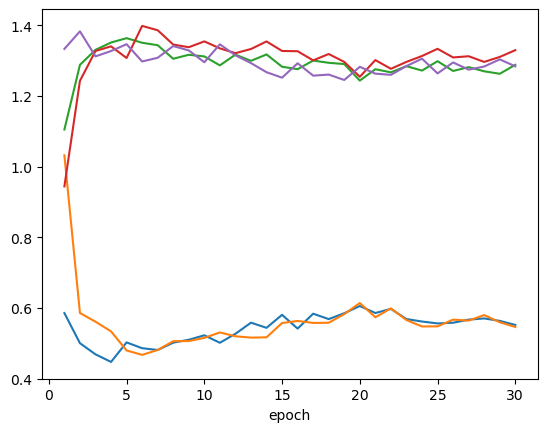

In [17]:
# df_ratio = df_clients_global.merge(lc, on=["epoch", "client_id"])
# df_ratio[similarities] = df_ratio[similarities].divide(df_ratio["loss"] ** 2, axis=0)

df_ratio = df_clients_global.merge(lc, on=["epoch", "client_id"])
df_ratio[similarities] = (1 / df_ratio[similarities]).multiply(df_ratio["loss"], axis=0)

df_ratio = df_ratio.groupby("epoch").apply(softmaxScheduler)
df_ratio.reset_index(inplace=True)
df_ratio.set_index("epoch", inplace=True)
df_ratio.groupby("client_id")["cosine"].plot()

client_id
1    AxesSubplot(0.125,0.11;0.775x0.77)
2    AxesSubplot(0.125,0.11;0.775x0.77)
3    AxesSubplot(0.125,0.11;0.775x0.77)
4    AxesSubplot(0.125,0.11;0.775x0.77)
5    AxesSubplot(0.125,0.11;0.775x0.77)
Name: cosine, dtype: object

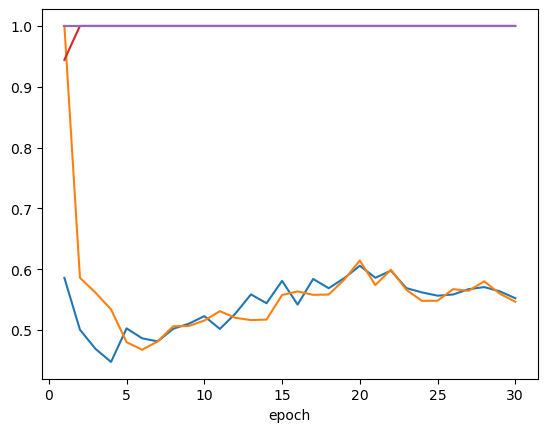

In [18]:
#clips every value in df_ratio that is greater than 1 to 1
df_ratio[similarities] = df_ratio[similarities].clip(0, 1)	
df_ratio.reset_index(inplace=True)
df_ratio.set_index("epoch", inplace=True)
df_ratio.groupby("client_id")["cosine"].plot()

## t-SNE style density estimation

In [7]:
similarities = ["cosine", "seuclidean", "euclidean"]
epochs = 30
base_path = "/home/mohkoh/Projects/Split_ECG_Classification/latent_space/multi_client_two_malicious_0.25_0.25"
metadata = pickle.load(open(os.path.join(base_path, "metadata.pickle"), "rb"))
df = pd.read_pickle(os.path.join(base_path, "client_1", "epoch_1.pickle"))
idxs = range(len(df))
multi_idx =  pd.MultiIndex.from_tuples(list(itertools.combinations(idxs, 2)), names=["i", "j"])

# # Generate Multi Index
# df = pd.read_pickle(os.path.join(base_path, "client_1", "epoch_1.pickle"))
# multi_idx =  pd.MultiIndex.from_tuples(list(itertools.combinations(range(len(df)), 2)), names=["i", "j"])

In [9]:
df_clients = client_scores(num_clients=5, num_workers=multiprocessing.cpu_count(), base_path=base_path, epochs=30, method="density", multi_idx=multi_idx, sigma=1, pooling="max", split="knn_10_euclidean")

Client 1:   0%|          | 0/30 [00:00<?, ?it/s]

In [8]:
df_clients = client_scores(num_clients=5, num_workers=multiprocessing.cpu_count(), base_path=base_path, epochs=30, method="similarity", pooling="max", split="knn_10_euclidean")

  0%|          | 0/30 [00:00<?, ?it/s]

In [9]:
## Per Client time for processing one epoch:

df = per_epoch_densities(client_id=1, base_path=base_path, epoch=1, similarities=["seuclidean"], sigma=1, pooling="max", split="knn_10_euclidean")

In [10]:
df

,epoch,label,client_id,seuclidean
0,1,1.0,1,0.115438
1,1,2.0,1,0.340974
2,1,4.0,1,0.086062
3,1,8.0,1,0.014577
4,1,16.0,1,0.053071


client_id
1    AxesSubplot(0.125,0.11;0.775x0.77)
2    AxesSubplot(0.125,0.11;0.775x0.77)
3    AxesSubplot(0.125,0.11;0.775x0.77)
4    AxesSubplot(0.125,0.11;0.775x0.77)
5    AxesSubplot(0.125,0.11;0.775x0.77)
Name: seuclidean, dtype: object

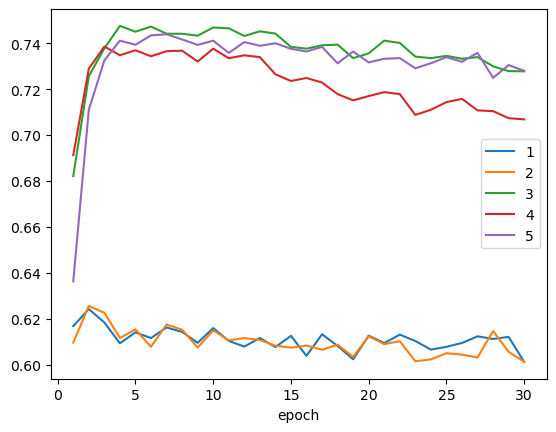

In [57]:
df_clients_global = df_clients.groupby(["client_id", "epoch"]).sum()
df_clients_global.reset_index(inplace=True)
df_clients_global.set_index("epoch", inplace=True)
df_clients_global.groupby("client_id")["seuclidean"].plot(legend=True)

In [204]:
df = pd.DataFrame()
for i in range(metadata["num_clients"]):
    df_i = pd.read_pickle(os.path.join(base_path, "client_" + str(i+1), "epoch_5.pickle"))
    df_i["client_id"] = i+1
    df = pd.concat([df, df_i], axis=0, ignore_index=True)

df = split_labels(df, split="knn_10_euclidean")  

In [214]:
X_c = df[["client_output_pooled", "label", "client_id"]]
X_c = X_c[X_c["client_id"] == 1]
X_c.reset_index(inplace=True, drop=True)
P = get_p_ij(np.array(X_c["client_output_pooled"].to_list()), sigma=1)
Y = X_c.label.unique()
sum([q_y(X_c, P, y) for y in Y])

0.6547619621426305

In [215]:
X_c = df[["client_output_pooled", "label", "client_id"]]
X_c = X_c[X_c["client_id"] == 2]
X_c.reset_index(inplace=True, drop=True)
P = get_p_ij(np.array(X_c["client_output_pooled"].to_list()), sigma=1)
Y = X_c.label.unique()
sum([q_y(X_c, P, y) for y in Y])

0.6657791045529443

In [216]:
X_c = df[["client_output_pooled", "label", "client_id"]]
X_c = X_c[X_c["client_id"] == 3]
X_c.reset_index(inplace=True, drop=True)
P = get_p_ij(np.array(X_c["client_output_pooled"].to_list()), sigma=1)
Y = X_c.label.unique()
sum([q_y(X_c, P, y) for y in Y])

0.782261764165706

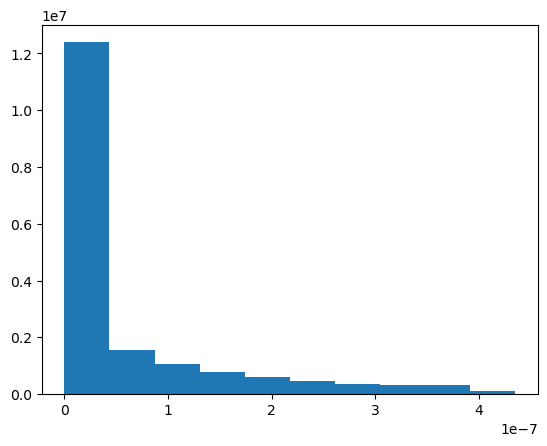

In [65]:
np.histogram(P)
plt.hist(P)
plt.show()

In [14]:
df_clients = pd.DataFrame(columns=["client_id"])
for idx in range(1, metadata["num_clients"] + 1):
    client_path = os.path.join(base_path, "client_" + str(idx))
    save_path = os.path.join(client_path, "similarities.pickle")
    df = compute_in_parallel2(client_path, epochs, similarities, sigma=2, num_workers=multiprocessing.cpu_count(), pooling=None, split="knn_10_euclidean")
    df["client_id"] = idx
    df_clients = pd.concat([df_clients, df], axis=0, ignore_index=True)

  0%|          | 0/30 [00:00<?, ?it/s]

KeyboardInterrupt: 

client_id
1    AxesSubplot(0.125,0.11;0.775x0.77)
2    AxesSubplot(0.125,0.11;0.775x0.77)
3    AxesSubplot(0.125,0.11;0.775x0.77)
4    AxesSubplot(0.125,0.11;0.775x0.77)
5    AxesSubplot(0.125,0.11;0.775x0.77)
Name: cosine, dtype: object

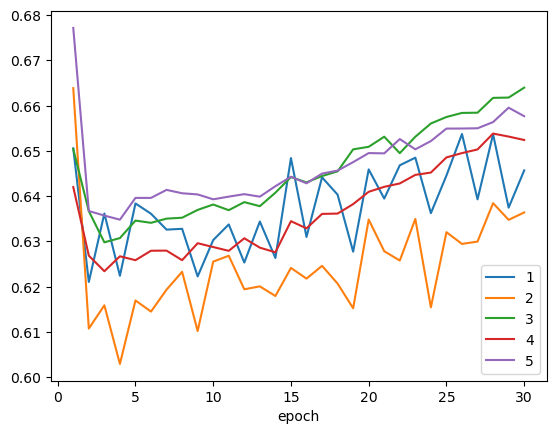

In [267]:
df_clients_global = df_clients.groupby(["client_id", "epoch"]).sum()
df_clients_global.reset_index(inplace=True)
df_clients_global.set_index("epoch", inplace=True)
df_clients_global.groupby("client_id")["cosine"].plot(legend=True)

## Testing the Detection Mechanism

In [59]:
# reads parameters from json file
import json


data = json.load(open("settings.json", "r"))
detection_params = data["detection_params"]
numclients = 5

latent_space_image = pd.DataFrame()
for i in range(1, numclients + 1):
    client_df = pd.read_pickle(os.path.join(base_path, "client_" + str(i), "epoch_10.pickle"))
    client_df["client_id"] = i
    latent_space_image = pd.concat([latent_space_image, client_df], axis=0, ignore_index=True)
    
detection_scores = pd.DataFrame()

In [60]:
def update_detection_scores(latent_space_image, detection_scores, epoch, stage="train"):
    latent_space_image = latent_space_image[latent_space_image["stage"] == stage]
    
    df_scores = pd.DataFrame()
    for client_id in tqdm(range(1, numclients + 1), desc="Client Detection Scores"):
        client_score = per_epoch_scores(epoch, client_id, df=latent_space_image, **detection_params)
        client_loss = latent_space_image[latent_space_image["client_id"] == client_id]["loss"].sum()
        client_score[detection_params["similarities"]] = (1 / client_score[detection_params["similarities"]]).multiply(client_loss, axis=0)
        df_scores = pd.concat([df_scores, client_score], ignore_index=True)
        
    df_scores = df_scores.groupby(["client_id", "epoch"]).mean().reset_index()
    df_scores = df_scores.groupby("epoch").apply(lambda x: medianAbsoluteDeviation(x, similarities=detection_params["similarities"]))
    df_scores = df_scores[["client_id", "epoch"] + detection_params["similarities"]]
    
    detection_scores = pd.concat([detection_scores, df_scores], axis=0, ignore_index=True)
        
    return detection_scores

In [61]:
detection_scores = update_detection_scores(latent_space_image, detection_scores, epoch=1, stage="val")

Client Detection Scores:   0%|          | 0/5 [00:00<?, ?it/s]

In [62]:
detection_scores

,client_id,epoch,cosine
0,1,1,0.492037
1,2,1,0.506814
2,3,1,0.000670
3,4,1,0.000000
4,5,1,0.000478
